In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np

In [19]:
# Training settings
args_batch_size = 64
args_test_batch_size = 1000
args_epochs = 20
args_lr = 0.001
args_momentum = 0.9
args_decay = 5e-4
args_seed = 1
args_log_interval = 2500
args_no_cuda = False
args_cuda = not args_no_cuda and torch.cuda.is_available()

torch.manual_seed(args_seed)
if args_cuda:
    torch.cuda.manual_seed(args_seed)


kwargs = {'num_workers': 1, 'pin_memory': True} if args_cuda else {}
# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1]
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                             ])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=4,
                                          shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

num_classes = len(classes)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # TODO: define your network here 
        
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0)
        self.weight1 = self.conv1.weight.data.numpy()
        self.features = nn.Sequential(
            # 32 * 32 * 3, CIFAR
            self.conv1,
            # (32 - 5) / 1 + 1 = 28, 28 * 28 * 6
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # (28 - 2) / 2 + 1 = 14, 14 * 14 * 6
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            # 14 - 5 + 1 = 10, 10 * 10 * 16
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 5 * 5 * 16
        )
        
        self.fc_layers = nn.Sequential(
            nn.Dropout(0.6),
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(inplace=True),
            nn.Dropout(0.6),
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, num_classes),
        )

    def forward(self, x):
        # TODO
        conv_features = self.features(x)
        flatten = conv_features.view(conv_features.size(0), -1)
        fc = self.fc_layers(flatten)
        #probas = F.softmax(logits, dim=1)
        return fc


model = Net()
if args_cuda:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args_lr, momentum=args_momentum, weight_decay=args_decay)

train_loss_list = []
test_loss_list  = []
valid_acc_list  = []

def train(epoch):
    model.train()
    loss_sum = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        if args_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        # use cross_entropy here, since there is no softmax function in my last layer
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args_log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data))
        
        loss_sum += loss.data
        total += 1
        
    train_loss_list.append(loss_sum / total)

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if args_cuda:
            data, target = data.cuda(), target.cuda()
        with torch.no_grad():
            data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target).data
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(test_loader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # preserve the accuracy for plot and comparison
    test_loss_list.append(test_loss)
    valid_acc_list.append(100. * correct / len(test_loader.dataset))


for epoch in range(1, args_epochs + 1):
    train(epoch)
    test(epoch)

Files already downloaded and verified
Files already downloaded and verified
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.305884
Train Epoch: 1 [10000/50000 (20%)]	Loss: 2.126789
Train Epoch: 1 [20000/50000 (40%)]	Loss: 1.975413
Train Epoch: 1 [30000/50000 (60%)]	Loss: 2.339995
Train Epoch: 1 [40000/50000 (80%)]	Loss: 2.182638

Test set: Average loss: 2.1010, Accuracy: 1972/10000 (20%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.807204
Train Epoch: 2 [10000/50000 (20%)]	Loss: 1.978794
Train Epoch: 2 [20000/50000 (40%)]	Loss: 2.142374
Train Epoch: 2 [30000/50000 (60%)]	Loss: 2.590717
Train Epoch: 2 [40000/50000 (80%)]	Loss: 2.279151

Test set: Average loss: 2.1076, Accuracy: 1847/10000 (18%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.744625
Train Epoch: 3 [10000/50000 (20%)]	Loss: 1.998114
Train Epoch: 3 [20000/50000 (40%)]	Loss: 2.458207
Train Epoch: 3 [30000/50000 (60%)]	Loss: 2.056008
Train Epoch: 3 [40000/50000 (80%)]	Loss: 2.030291

Test set: Average loss: 2.1227, Accuracy: 1790/10000 (18%)

Train 

KeyboardInterrupt: 

In [24]:
# Weight initialization


# Training settings
args_batch_size = 64
args_test_batch_size = 1000
args_epochs = 20
args_lr = 0.001
args_momentum = 0.9
args_decay = 5e-4
args_seed = 1
args_log_interval = 2500
args_no_cuda = False
args_cuda = not args_no_cuda and torch.cuda.is_available()

torch.manual_seed(args_seed)
if args_cuda:
    torch.cuda.manual_seed(args_seed)


kwargs = {'num_workers': 1, 'pin_memory': True} if args_cuda else {}
# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1]
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                             ])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=4,
                                          shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

num_classes = len(classes)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # TODO: define your network here 
            
        self.conv1 = nn.Conv2d(3, 6, 5)
        torch.nn.init.kaiming_normal_(self.conv1.weight)
        # for visualize the filters in the first conv layer
        self.weight1 = self.conv1.weight.data.numpy()
        
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        torch.nn.init.kaiming_normal_(self.conv2.weight)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        torch.nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(120, 84)
        torch.nn.init.kaiming_normal_(self.fc2.weight)
        self.fc3 = nn.Linear(84, 10)
        
#         self.features = nn.Sequential(
#             # 32 * 32 * 3, CIFAR
#             self.conv1,
#             # (32 - 5) / 1 + 1 = 28, 28 * 28 * 6
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             # (28 - 2) / 2 + 1 = 14, 14 * 14 * 6
#             nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
#             # 14 - 5 + 1 = 10, 10 * 10 * 16
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             # 5 * 5 * 16
#         )  
        
#         self.fc_layers = nn.Sequential(
#             nn.Dropout(0.6),
#             nn.Linear(16 * 5 * 5, 120),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.6),
#             nn.Linear(120, 84),
#             nn.ReLU(inplace=True),
#             nn.Linear(84, num_classes),
#         )

    def forward(self, x):
        # TODO
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
        # conv_features = self.features(x)
        # flatten = conv_features.view(conv_features.size(0), -1)
        # fc = self.fc_layers(flatten)
        # probas = F.softmax(logits, dim=1)
        # return fc


model = Net()
if args_cuda:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args_lr, momentum=args_momentum, weight_decay=args_decay)

train_loss_list = []
test_loss_list  = []
valid_acc_list  = []

def train(epoch):
    model.train()
    loss_sum = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        if args_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        # use cross_entropy here, since there is no softmax function in my last layer
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args_log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data))
        
        loss_sum += loss.data
        total += 1
        
    train_loss_list.append(loss_sum / total)

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if args_cuda:
            data, target = data.cuda(), target.cuda()
        with torch.no_grad():
            data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target).data
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(test_loader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # preserve the accuracy for plot and comparison
    test_loss_list.append(test_loss)
    valid_acc_list.append(100. * correct / len(test_loader.dataset))


for epoch in range(1, args_epochs + 1):
    train(epoch)
    test(epoch)

Files already downloaded and verified
Files already downloaded and verified
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.323506
Train Epoch: 1 [10000/50000 (20%)]	Loss: 2.142912
Train Epoch: 1 [20000/50000 (40%)]	Loss: 2.745064
Train Epoch: 1 [30000/50000 (60%)]	Loss: 1.093693
Train Epoch: 1 [40000/50000 (80%)]	Loss: 0.813302

Test set: Average loss: 1.4207, Accuracy: 4883/10000 (49%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.992471
Train Epoch: 2 [10000/50000 (20%)]	Loss: 1.608712
Train Epoch: 2 [20000/50000 (40%)]	Loss: 1.194683
Train Epoch: 2 [30000/50000 (60%)]	Loss: 2.376128
Train Epoch: 2 [40000/50000 (80%)]	Loss: 1.102659

Test set: Average loss: 1.3868, Accuracy: 5143/10000 (51%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.767755
Train Epoch: 3 [10000/50000 (20%)]	Loss: 1.568396
Train Epoch: 3 [20000/50000 (40%)]	Loss: 0.533004
Train Epoch: 3 [30000/50000 (60%)]	Loss: 2.075071
Train Epoch: 3 [40000/50000 (80%)]	Loss: 0.812473

Test set: Average loss: 1.3111, Accuracy: 5327/10000 (53%)

Train 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


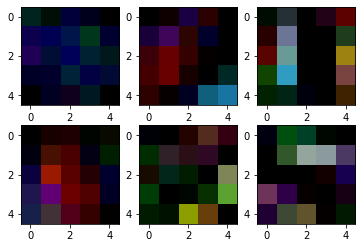

In [30]:
# Visualize the filters learned in the first convolutional layer

weight1 = model.conv1.weight.detach().numpy()

plt.figure()
plt.subplot(231)
plt.imshow(weight1[0, ...].T)
plt.subplot(232)
plt.imshow(weight1[1, ...].T)
plt.subplot(233)
plt.imshow(weight1[2, ...].T)
plt.subplot(234)
plt.imshow(weight1[3, ...].T)
plt.subplot(235)
plt.imshow(weight1[4, ...].T)
plt.subplot(236)
plt.imshow(weight1[5, ...].T)

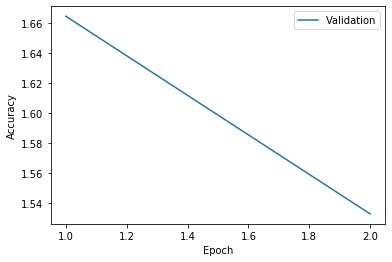

In [10]:
#plt.plot(np.arange(1, args_epochs+1), train_acc_list, label='Training')
#plt.plot(np.arange(1, args_epochs+1), valid_acc_list, label='Validation')

#plt.plot(np.arange(1, args_epochs+1), test_loss_list, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()